# 1 - Querying top miner UID

In [1]:
import bittensor as bt

USE_TESTNET=True

if USE_TESTNET:
    metagraph = bt.metagraph(netuid=118, network="test")
else:
    metagraph = bt.metagraph(netuid=2, network="finney")

top_miner_uid = int(metagraph.incentive.argmax())
print(top_miner_uid)


2


# 2 - Demonstration of Rewards

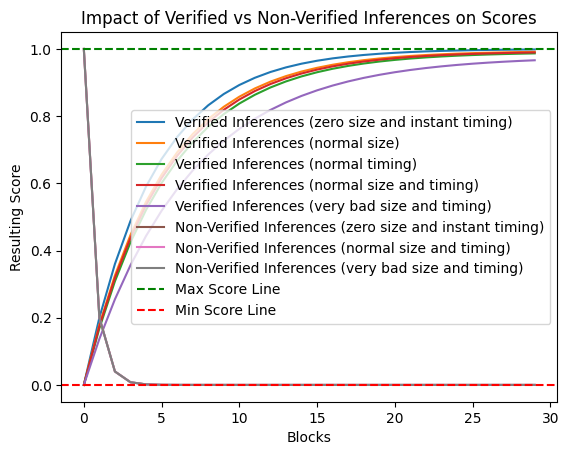

<Figure size 3000x1800 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
from _validator.reward import reward

try:
    import matplotlib
except ImportError:
    %pip install matplotlib

PLOT_BLOCKS = 30

# Define plotter
def plot_values(values, label, linestyle='-'):
    plt.plot([i for i in range(PLOT_BLOCKS)], values, label=label, linestyle=linestyle)

# Generate mock reward values
def generate_proven_values(initial_score, response, size=0, timing=0):
    values = [initial_score]
    for _ in range(PLOT_BLOCKS - 1):
        initial_score = reward(1, initial_score, response, 1, timing, size)
        values.append(initial_score)
    return values

# Generate and plot all the values
plot_values(generate_proven_values(0, True), 'Verified Inferences (zero size and instant timing)')
plot_values(generate_proven_values(0, True, 30000), 'Verified Inferences (normal size)')
plot_values(generate_proven_values(0, True, 0, 30), 'Verified Inferences (normal timing)')
plot_values(generate_proven_values(0, True, 21353, 10), 'Verified Inferences (normal size and timing)')
plot_values(generate_proven_values(0, True, 1000000, 60), 'Verified Inferences (very bad size and timing)')
plot_values(generate_proven_values(1, False), 'Non-Verified Inferences (zero size and instant timing)')
plot_values(generate_proven_values(1, False, 30000, 40), 'Non-Verified Inferences (normal size and timing)')
plot_values(generate_proven_values(1, False, 1000000, 60), 'Non-Verified Inferences (very bad size and timing)')

# Plotting configurations
plt.axhline(y=1, color='g', linestyle='--', label='Max Score Line')
plt.axhline(y=0, color='r', linestyle='--', label='Min Score Line')
plt.xlabel('Blocks')
plt.ylabel('Resulting Score')
plt.title('Impact of Verified vs Non-Verified Inferences on Scores')
plt.legend()
plt.figure(figsize=(10, 6), dpi=300)
plt.show()


# 3 - N/A